# Astrophysical Gamma-Ray Background

This notebook details how to construct a basic astrophysical background for use in Dark Matter parameter inference for CTA data from the Galactic Centre. The whole background for an analysis would require these components as well as a component for the rate/probability of mis-identified cosmic-rays. This is detailed further in the `prior_class` notebook and the module `gammabayes/default_file_setup.py` contains a function automatically calculates everything contained here once you've specified the axes to be evaluated along.

For now we split the astrophysical background into two components: the diffuse background and the localised source background. These are then combined and the effective area of the CTA is applied to them to simulate the flux of events from these models detected by the CTA. This notebook will detail how we construct interpolation functions for the background that are then used within the prior classes as a kind of look-up table.

## Localised source background

As the CTA is an imaging atmospheric Cherenkov Telescope (IACT) the localised source background from another IACT, the H.E.S.S experiment, would be a relevant source of localised source background. We do this by extracting the sources in the H.E.S.S catalogue within a reasonable distance of the Galactic Centre. This is mostly done with the use of the `Gammapy` package functions but the base files used to construct both this background and the diffuse background are contained within the `gammabayes/package_data` folder.

We first import the needed packages and functions to extract the H.E.S.S source catalogue.

In [1]:
from astropy import units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt



from gammapy.catalog import SourceCatalogHGPS

import numpy as np
from gammapy.maps import Map, MapAxis, WcsGeom

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

/Users/lpin0002/anaconda3/envs/testywesty/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We then import some helpful auxillary functions that aren't necessarily needed but make the code much simpler and efficient.

In [2]:


from scipy import interpolate
from scipy.integrate import simps
from scipy import special
from matplotlib.colors import LogNorm

Now that we have the setup completed, we can create an object that contains the whole H.E.S.S. catalogue by extracting them from the `hgps_catalog_v1.fits.gz` file within the `GammaBayes` package data folder and then convert them to source models.

In [3]:
hess_catalog = SourceCatalogHGPS("../gammabayes/package_data/hgps_catalog_v1.fits.gz")

hess_models = hess_catalog.to_models()

print(f"\nThere are {len(hess_models)} sources within the HGPS.")

/Users/lpin0002/anaconda3/envs/testywesty/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/lpin0002/anaconda3/envs/testywesty/lib/python3.11/site-packages/gammapy/modeling/models/spatial.py:554: RuntimeWarning: invalid value encountered in multiply
  return u.Quantity(norm * np.exp(exponent).value, "sr-1", copy=False)



There are 96 sources within the HGPS.


At the moment the analysis is discrete, so we define axes along which we sample these models for use within the analysis. Default axes are contained within the `gammabayes/utils.py` file.

In [4]:
from gammabayes.utils import log10eaxistrue, longitudeaxistrue, latitudeaxistrue

`Gammapy` then uses some specific objects to define where to evaluate models. We won't go into too much detail here, but more information can be found within the  `Gammapy` documentation.

In [5]:
trueenergyaxis = 10**log10eaxistrue*u.TeV

energy_axis_true = MapAxis.from_nodes(trueenergyaxis, interp='log', name="energy_true")

HESSgeom = WcsGeom.create(
    skydir=SkyCoord(0, 0, unit="deg", frame='galactic'),
    binsz=longitudeaxistrue[1]-longitudeaxistrue[0],
    width=(longitudeaxistrue[-1]-longitudeaxistrue[0]+longitudeaxistrue[1]-longitudeaxistrue[0], latitudeaxistrue[-1]-latitudeaxistrue[0]+longitudeaxistrue[1]-longitudeaxistrue[0]),
    frame="galactic",
    proj="CAR",
    axes=[energy_axis_true],
)

HESSmap = Map.from_geom(HESSgeom)
HESSmap

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy_true']
	shape : (35, 30, 681)
	ndim  : 3
	unit  : 
	dtype : float32

Our, and `Gammapy`'s default energy axes are log-spaced. Let's have a quick look at specific values within the axis.

In [6]:
# The energy axis that has actually been stored
hessenergyaxis = energy_axis_true.center.value 

# Calculating the log_{10} values of this axis and looking at some of the differences between values. They should all be equal
np.diff(np.log10(hessenergyaxis))[:50]

array([0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005,
       0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005,
       0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005,
       0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005,
       0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005,
       0.005, 0.005, 0.005, 0.005, 0.005])

Let's have a quick look at one of the models we've extracted and what information is contained within it.

In [7]:
print(hess_models[0])

SkyModel

  Name                      : HGPSC 001
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      1.354   +/-    0.08             
    amplitude                     :   1.15e-12   +/- 3.3e-13 1 / (TeV s cm2)
    reference             (frozen):      1.697       TeV         
    lambda_                       :      0.082   +/-    0.01 1 / TeV     
    alpha                 (frozen):      1.000                   
    lon_0                         :    263.969   +/-    0.02 deg         
    lat_0                         :     -3.344   +/-    0.03 deg         
    sigma                         :      0.237   +/-    0.02 deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         




So we have information on the:
- source name (HGPSC 001)
- spectral model (Exponential Cut Off Power Law)
- spatial model (Gaussian)
- model parameters

What we want is to extract the sources near the Galactic Centre, essentially those with lon_0 < 5 deg and lat_0 < 5 deg in the model parameters above that represent the centre of the source.

In [8]:
count=0 # To keep track of the number of sources satisfying the conditions

full_hess_flux = 0 #Extracting the flux values for the sources along the axes previously defined

for idx, model in enumerate(hess_models):
    
    # We will store the longitude 'l' and latitude 'b' values of the source
    temp_l_value = model.spatial_model.position.l.value
    temp_b_value = model.spatial_model.position.b.value
    
    
    # The unit convention for the longitude works as 357, 358, 359, 0, 1, 2
        # we will make it so that it's -3, -2, -1, 0, 1, 2
    if temp_l_value>180:
        temp_l_value=temp_l_value-360
        
        
    # If the location of the source satisfies the criteria above then we start to store it's flux values
    if np.abs(temp_l_value)<5 and np.abs(temp_b_value)<5:
        
        try:
            # We extract the flux by assigning it to the HESSmap object
            HESSmap.quantity = model.evaluate_geom(HESSmap.geom)
            
            # We can then extract the actual values by referencing the data of this object
            startdata = HESSmap.data
            
            # Removing nan values, '~' is a shortcut for 'not'
            data = startdata[~np.isnan(startdata)]
            
            # If statement to catch sources that have no obervable flux within the region
            if data.size!=0:
                
                # Making sure the data shape is consistent
                data = data.reshape(startdata.shape)
                
                # Adding the flux from this model to the total flux
                full_hess_flux+=data
                
        except:
            print("Something weird happened")
            print(idx, '\n\n')
            
        count+=1
        
# Transposing the longitude and latitude values such that the order of indices goes [logenergy_index, longitude_index, latitude_index]
full_hess_flux = np.transpose(full_hess_flux, axes=(0,2,1))
full_hess_flux*=100**2
full_hess_flux = np.flip(full_hess_flux, axis=1)

Now that we've extracted the flux, we want to make sure we have the correct units for later analysis. For most analyis we use the units: TeV, s, sr and m.

In [9]:
HESSmap.quantity.unit

Unit("1 / (TeV s sr cm2)")

So we needed to convert the units such that they are $\frac{1}{\textrm{TeV s sr m}^2}$, hence the multiplication by the factor $100^2$.

We quickly want to double check that the angular axes within the `Gammapy` object match the ones we've defined so let's quickly have a look at them.

In [10]:
hessgeom = HESSmap.geom

# Extracting the longitudevalues
hesslonvals = hessgeom.get_coord().lon.value[0][0]

# Reversing the order as the order is flipped by convention
hesslonvals = hesslonvals[::-1]

# Again converting the longitude axis from 357,358,359,0,1,2,3 to -3,-2,-1,0,1,2,3
hesslonvals[hesslonvals>180] = hesslonvals[hesslonvals>180]-360


# Extracting the latitude values
hesslatvals = hessgeom.get_coord().lat.value[0][:,0]

# Checking that the shape matches and the max and min values
print(hesslonvals.shape, hesslonvals.min(), hesslonvals.max(), hesslonvals[:10])
print(hesslatvals.shape, hesslatvals.min(), hesslatvals.max(), hesslatvals[:10])

(35,) -3.5 3.5000000000000027 [-3.5        -3.29411765 -3.08823529 -2.88235294 -2.67647059 -2.47058824
 -2.26470588 -2.05882353 -1.85294118 -1.64705882]
(30,) -2.985294117647061 2.985294117647061 [-2.98529412 -2.77941176 -2.57352941 -2.36764706 -2.16176471 -1.95588235
 -1.75       -1.54411765 -1.33823529 -1.13235294]


Which roughly should match

In [11]:
print(longitudeaxistrue.shape, longitudeaxistrue.min(), longitudeaxistrue.max())
print(latitudeaxistrue.shape, latitudeaxistrue.min(), latitudeaxistrue.max())

(35,) -3.5 3.5
(30,) -3.0 3.0


Finally, let's have an actual look at the sources we've extracted.

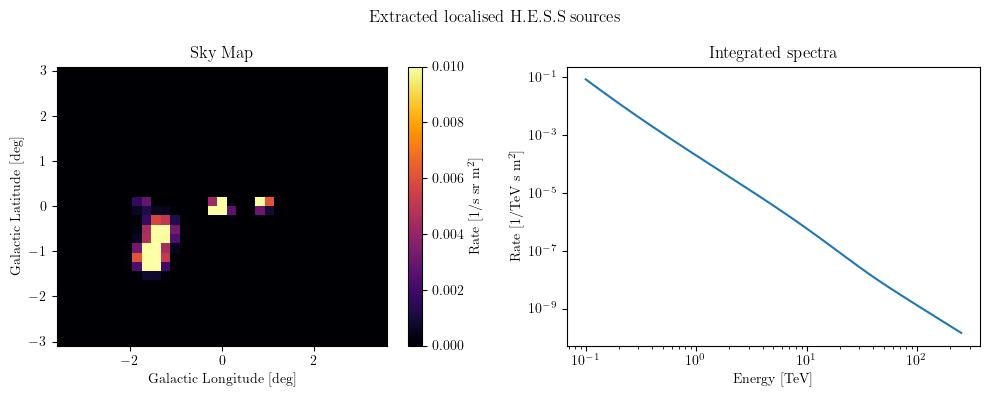

In [12]:
plt.figure(figsize=(10,4))
plt.suptitle('Extracted localised H.E.S.S sources')
plt.subplot(1,2,1)
plt.title('Sky Map')
plt.pcolormesh(hesslonvals, 
               hesslatvals, 
               np.sum(full_hess_flux[:-1,:,:].T * np.diff(log10eaxistrue), axis=-1), cmap='inferno', vmax=1e-2)
plt.xlabel('Galactic Longitude [deg]')
plt.ylabel('Galactic Latitude [deg]')
plt.colorbar(label=r'Rate [1/s sr m$^2$]')


plt.subplot(1,2,2)
plt.title('Integrated spectra')
plt.plot(hessenergyaxis,  np.sum(full_hess_flux*np.diff(longitudeaxistrue)[0]*np.diff(latitudeaxistrue)[0], axis=(1,2)))
plt.xlabel('Energy [TeV]')
plt.ylabel(r'Rate [1/TeV s m$^2$]')
plt.loglog()
plt.tight_layout()
plt.show()

# Diffuse Background Extraction

Now let's extract the diffuse source background. The way that this has been set-up is that we presume the spatial morphology of the diffuse background to be independent of the energy, this is not necessarily true but is approximately correct at least for the Fermi Pass 8 IEM model.

First let's import the relevant functions/libraries and define a handy function for later on.

In [13]:
from gammapy.modeling.models import (
    PowerLawNormSpectralModel,
    PowerLawSpectralModel,
    SkyModel,
    TemplateSpatialModel,
)

def powerlaw(energy, index, phi0=1):
    return phi0*energy**(index)

Once again we utilise the package `Gammapy` to extract the Fermi IEM model for the Galactic Centre as below, more information on this extraction can be found on the 'Fermi-LAT with Gammapy' Gammapy documentation page.

In [14]:
template_diffuse_skymap = TemplateSpatialModel.read(
    filename="../gammabayes/package_data/gll_iem_v06_gc.fits.gz", normalize=True
)


diffuse_iem = SkyModel(
    spatial_model=template_diffuse_skymap,
    spectral_model=PowerLawSpectralModel(),
    name="diffuse-iem",
)
diffuse_iem


SkyModel(spatial_model=<gammapy.modeling.models.spatial.TemplateSpatialModel object at 0x10d746850>, spectral_model=<gammapy.modeling.models.spectral.PowerLawSpectralModel object at 0x1519dfcd0>)temporal_model=None)

We then have that the longitude and latitude axis are in the wrong order, so we transpose those two axes. The longitudeaxis is then flipped, so we order it using `np.flip` along that axis.

In [15]:
fermievaluated = np.flip(np.transpose(diffuse_iem.evaluate_geom(HESSgeom), axes=(0,2,1)), axis=1).to(1/u.TeV/u.s/u.sr/(u.m**2))

We then want to integrate or average over the energy component of the map and then normalise it, so we can use our own definition of the energy spectrum to match the 2021 'Sensitivity to a dark matter signal from the Galactic Centre' by the CTA Consortium. This paper uses the power-law model from 'Diffuse Cosmic Rays Shining in the Galactic Center: A Novel Interpretation of H.E.S.S. and Fermi-LAT γ -Ray Data', Gaggero et al. 2017

In [16]:
fermi_integral_values= special.logsumexp(np.log(fermievaluated.value.T)+np.log(10**log10eaxistrue)+np.log(np.log(10))+np.log(np.diff(log10eaxistrue)[0]), axis=2).T
# fermievaluated_normalised = np.log(fermievaluated.value) - fermi_integral_values

fermi_integral_values = fermi_integral_values - special.logsumexp(fermi_integral_values+np.log(np.diff(longitudeaxistrue)[0]*np.diff(latitudeaxistrue)[0]))

# Slight change in normalisation due to the use of m^2 not cm^2
fermi_gaggero = np.exp(fermi_integral_values+np.log(powerlaw(10**log10eaxistrue, index=-2.41, phi0=1.36*1e-4))[:, np.newaxis, np.newaxis])
fermi_gaggero.shape

(681, 35, 30)

Let's plot what this now looks like.

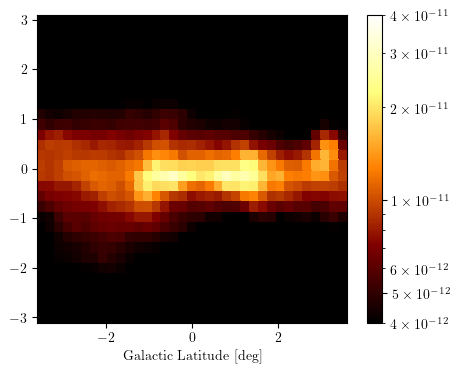

In [17]:
fig, ax = plt.subplots(figsize=(5,4))
# plt.subplot(121)
# plt.plot(10**log10eaxistrue, 
#          np.sum(fermi_gaggero*np.diff(longitudeaxistrue)[0]*np.diff(latitudeaxistrue)[0], axis=(1,2)))
# plt.loglog()

# plt.subplot(122)
cax = ax.pcolormesh(longitudeaxistrue, latitudeaxistrue, fermi_gaggero[-1, :, :].T, cmap='afmhot', norm=LogNorm(vmin=4e-12, vmax=4e-11),)
cax.set_edgecolor('face')
plt.xlabel('Galactic Longitude [deg]')
plt.xlabel('Galactic Latitude [deg]')

cbar = fig.colorbar(cax, ticks=[5e-12, 1e-11, 5e-11])
cbar.ax.set_yticklabels([r'$5\times 10^{-12}$', r'$1\times 10^{-11}$', r'$5\times 10^{-11}$'])
plt.savefig('Diffuse_BKG_Spatial_Map.pdf')
plt.show()


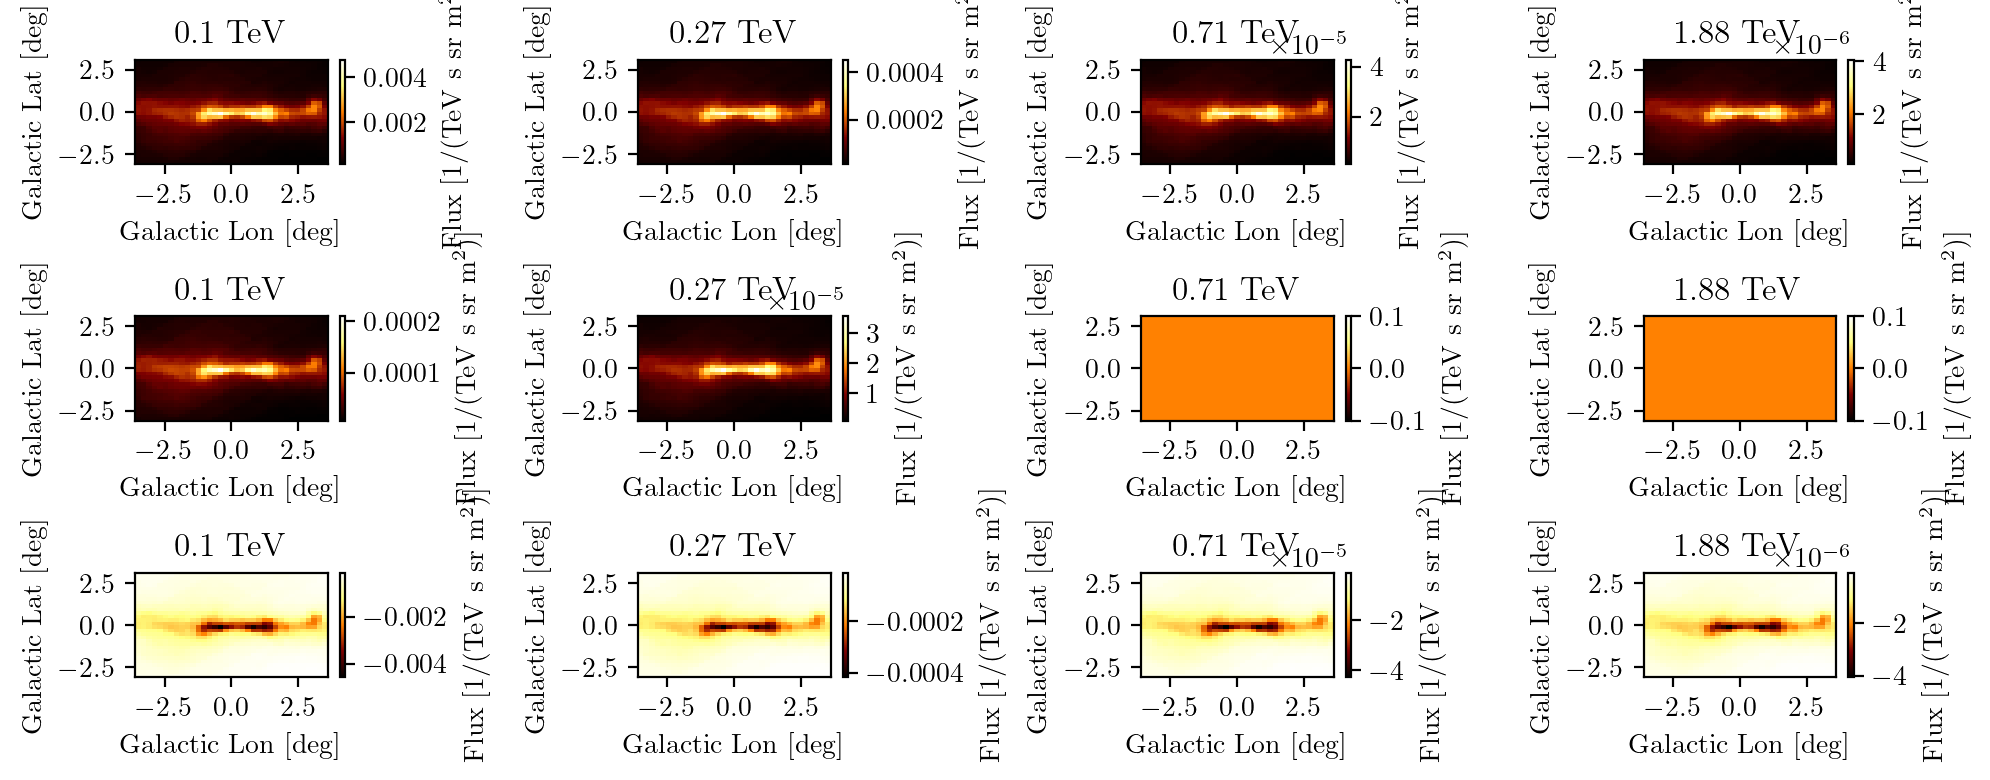

In [18]:

plt.figure(figsize=(10,4), dpi=200)

counter=1
for idx in np.arange(0, log10eaxistrue.shape[0], int(log10eaxistrue.shape[0]/8)):
    plt.subplot(3,4,counter)
    plt.title(f'{round(10**log10eaxistrue[idx],2)} TeV')
    plt.pcolormesh(hesslonvals, hesslatvals, fermi_gaggero[idx].T, cmap='afmhot')
    plt.colorbar(label=r'Flux [1/(TeV s sr m$^2$)]')
    plt.xlabel('Galactic Lon [deg]')
    plt.ylabel('Galactic Lat [deg]')
    counter+=1
    if counter>4:
        break


counter=1
for idx in np.arange(0, log10eaxistrue.shape[0], int(log10eaxistrue.shape[0]/8)):
    plt.subplot(3,4,counter+4)
    plt.title(f'{round(10**log10eaxistrue[idx],2)} TeV')
    plt.pcolormesh(hesslonvals, hesslatvals, fermievaluated[idx].T.value, cmap='afmhot')
    plt.colorbar(label=r'Flux [1/(TeV s sr m$^2$)]')
    plt.xlabel('Galactic Lon [deg]')
    plt.ylabel('Galactic Lat [deg]')
    counter+=1
    if counter>4:
        break
    
    
counter=1
for idx in np.arange(0, log10eaxistrue.shape[0], int(log10eaxistrue.shape[0]/8)):
    plt.subplot(3,4,counter+8)
    plt.title(f'{round(10**log10eaxistrue[idx],2)} TeV')
    plt.pcolormesh(hesslonvals, hesslatvals, fermievaluated[idx].T.value-fermi_gaggero[idx].T, cmap='afmhot')
    plt.colorbar(label=r'Flux [1/(TeV s sr m$^2$)]')
    plt.xlabel('Galactic Lon [deg]')
    plt.ylabel('Galactic Lat [deg]')
    counter+=1
    if counter>4:
        break

plt.tight_layout()
plt.show()

In [19]:
fermiunit = fermievaluated.unit
fermiunit

Unit("1 / (TeV s sr m2)")

# Adding the two astrophysical components together

In [20]:
fermiplotmap = fermievaluated.value
# combinedplotmap = np.logaddexp(np.log(fermi_gaggero), np.log(full_hess_flux))
combinedplotmap = np.log(fermi_gaggero)

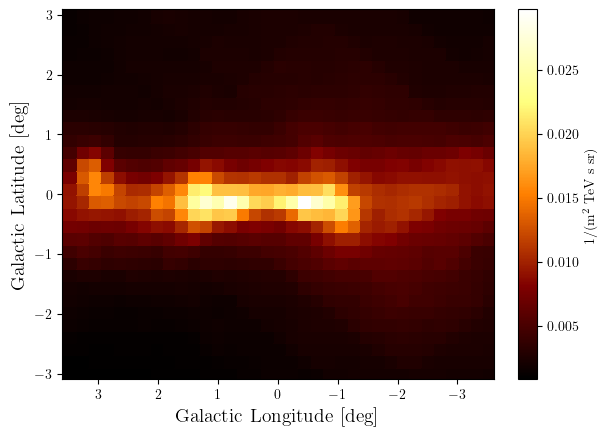

In [21]:


fig6, ax = plt.subplots()
pcol = plt.pcolormesh(hesslonvals, hesslatvals, 
                      np.exp(special.logsumexp(combinedplotmap.T+np.log(10**log10eaxistrue),axis=-1)), cmap='afmhot')#,
                      #vmin=1e-6, vmax=3e-5)
pcol.set_edgecolor('face')

plt.xlabel("Galactic Longitude [deg]", size=14)
ax.invert_xaxis()

plt.ylabel("Galactic Latitude [deg]", size=14)
ax.set_aspect(1)
plt.colorbar(fraction=0.05, label=r"1/(m$^2$ TeV s sr)")
plt.show()

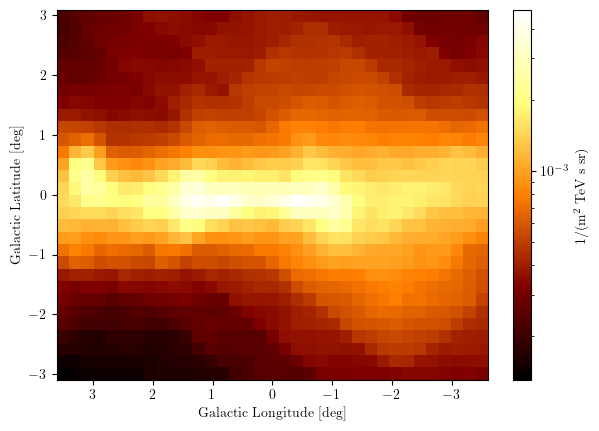

In [22]:
fig6, ax = plt.subplots(dpi=100)
plt.pcolormesh(hesslonvals, hesslatvals, np.exp(np.max(combinedplotmap,axis=0).T), cmap='afmhot', norm=LogNorm())#, vmax=1e-5)
plt.xlabel("Galactic Longitude [deg]")
ax.invert_xaxis()
plt.ylabel("Galactic Latitude [deg]")
ax.set_aspect(1)
plt.colorbar(fraction=0.05, label=r"1/(m$^2$ TeV s sr)")

plt.show()

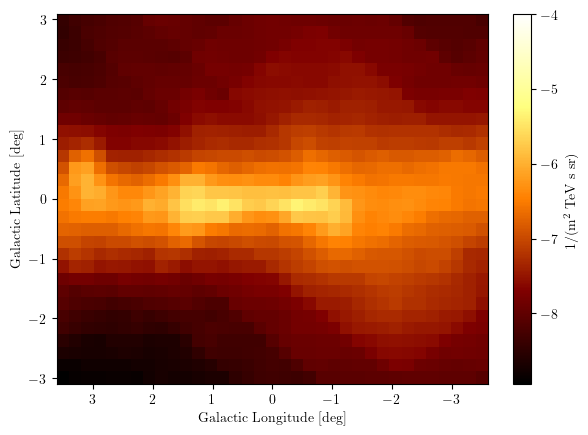

In [23]:
fig6, ax = plt.subplots(dpi=100)
plt.pcolormesh(hesslonvals, hesslatvals, np.max(combinedplotmap,axis=0).T, cmap='afmhot', vmax=-4)
plt.xlabel("Galactic Longitude [deg]")
ax.invert_xaxis()
plt.ylabel("Galactic Latitude [deg]")
ax.set_aspect(1)
plt.colorbar(fraction=0.05, label=r"1/(m$^2$ TeV s sr)")

plt.show()

In [24]:
from gammabayes.utils import irfs

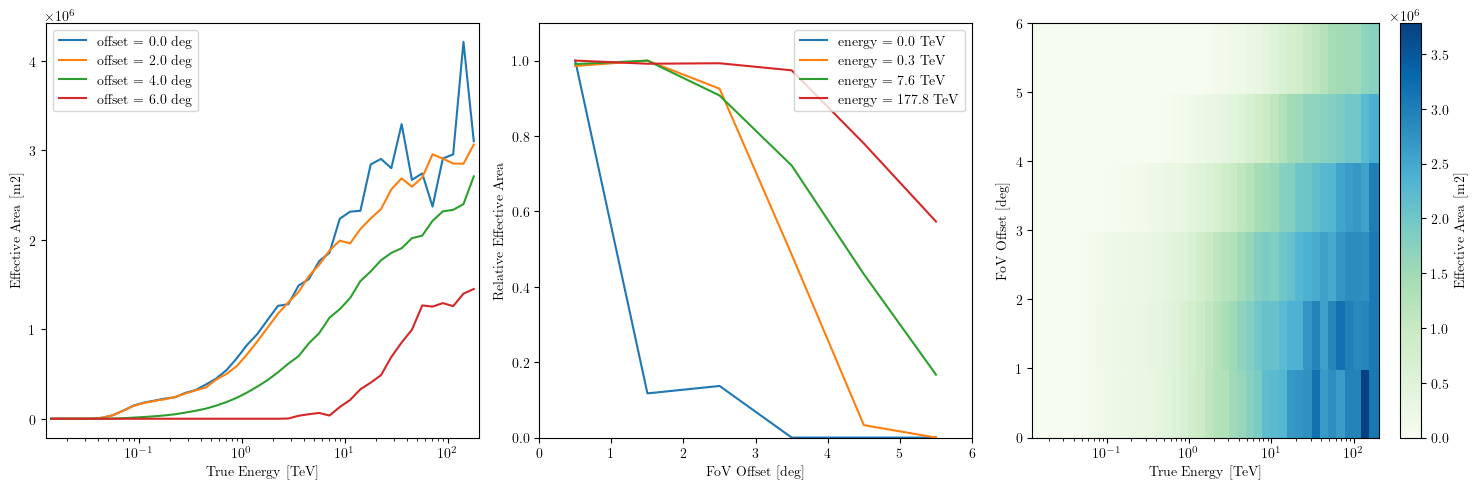

In [25]:
aeff = irfs['aeff']
aeff.peek()

In [26]:
aefffunc = lambda energy, offset: aeff.evaluate(energy_true = energy*u.TeV, offset=offset*u.deg).to(u.m**2).value

In [27]:
energymesh, lonmesh, latmesh = np.meshgrid(10**log10eaxistrue, longitudeaxistrue, latitudeaxistrue, indexing='ij')
print(lonmesh.shape)

(681, 35, 30)


In [28]:
aefftable = aefffunc(energymesh, np.sqrt((lonmesh**2)+(latmesh**2)))

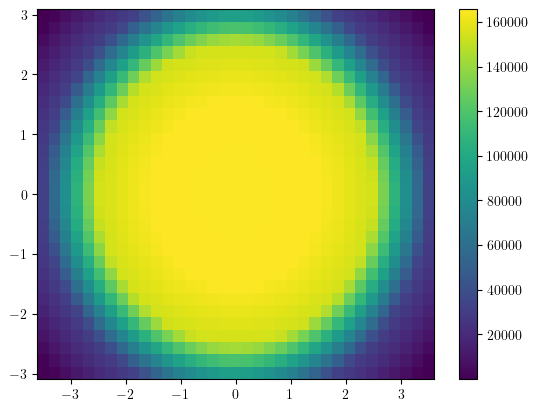

In [29]:
plt.pcolormesh(hesslonvals, hesslatvals, aefftable[0,:,:].T)
plt.colorbar()
plt.show()

# Adding the Aeff to the map

In [30]:
combinedplotmapwithaeff = np.exp(combinedplotmap+np.log(aefftable))
combinedplotmapwithaeff = combinedplotmapwithaeff

spatialplotcombined = np.sum((combinedplotmapwithaeff.T*10**log10eaxistrue*np.log(10)*(log10eaxistrue[1]-log10eaxistrue[0])).T, axis=0)
spatialplotcombinedmaxvalue = np.max(spatialplotcombined)

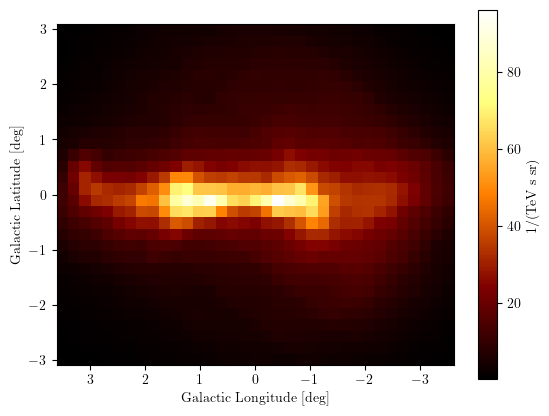

In [31]:
fig, ax = plt.subplots(1,1, dpi=100)
plt.pcolormesh(hesslonvals, hesslatvals, spatialplotcombined.T, 
               vmax=spatialplotcombinedmaxvalue/1e0, vmin=spatialplotcombinedmaxvalue/5e2, cmap='afmhot')
plt.xlabel("Galactic Longitude [deg]")
plt.ylabel("Galactic Latitude [deg]")
ax.invert_xaxis()
plt.colorbar(label = r"1/(TeV s sr)")
ax.set_aspect(1)

plt.show()

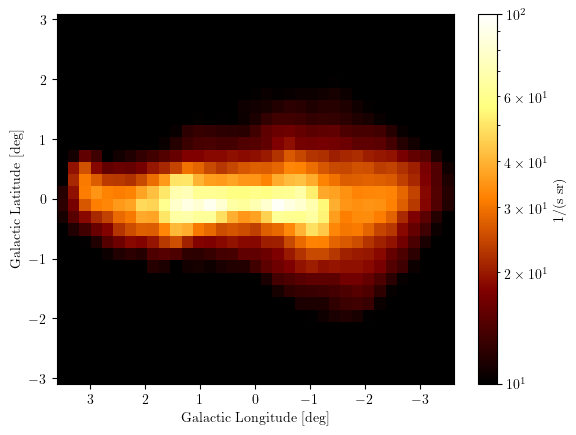

In [32]:
fig, ax = plt.subplots(1,1, dpi=100)
plt.pcolormesh(hesslonvals, hesslatvals, spatialplotcombined.T, norm=LogNorm(vmin=1e1, vmax=1e2), cmap='afmhot')
plt.xlabel("Galactic Longitude [deg]")
plt.ylabel("Galactic Latitude [deg]")
ax.invert_xaxis()
plt.colorbar(label = r"1/(s sr)")
plt.savefig('astrobkg_skymap.pdf')
plt.show()

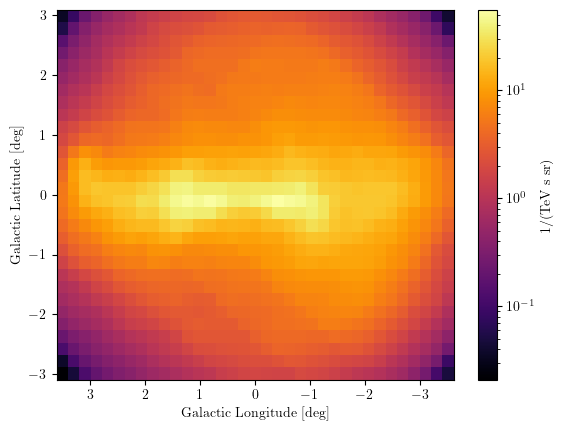

In [33]:
fig, ax = plt.subplots(1,1)
plt.pcolormesh(hesslonvals, hesslatvals, np.mean(combinedplotmapwithaeff, axis=0).T, norm=LogNorm(), cmap='inferno')
plt.xlabel("Galactic Longitude [deg]")
plt.ylabel("Galactic Latitude [deg]")
ax.invert_xaxis()
plt.colorbar(label = r"1/(TeV s sr)")
plt.show()

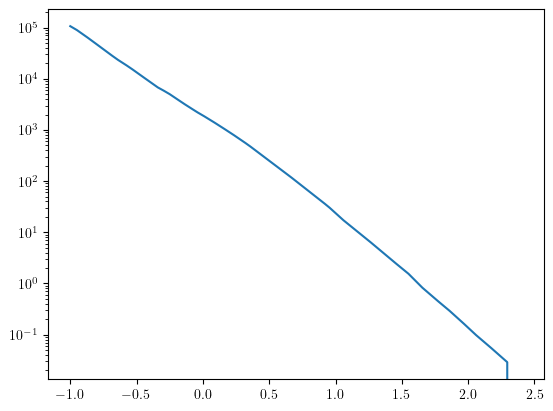

In [34]:
fig, ax = plt.subplots(1,1)
plt.plot(log10eaxistrue, np.sum(combinedplotmapwithaeff, axis=(1,2)))
plt.yscale('log')
plt.show()

In [35]:
np.save("../gammabayes/package_data/unnormalised_astrophysicalbackground.npy", combinedplotmapwithaeff)

In [36]:
from gammabayes.utils import bkgdist

lonmeshtrue, log10emeshtrue, latmeshtrue = np.meshgrid(longitudeaxistrue, log10eaxistrue, latitudeaxistrue)

logbkgpriorvalues = np.squeeze(np.logaddexp(bkgdist(log10emeshtrue, lonmeshtrue,latmeshtrue),np.log(combinedplotmapwithaeff)))
logbkgpriorvalues.shape

(681, 35, 30)

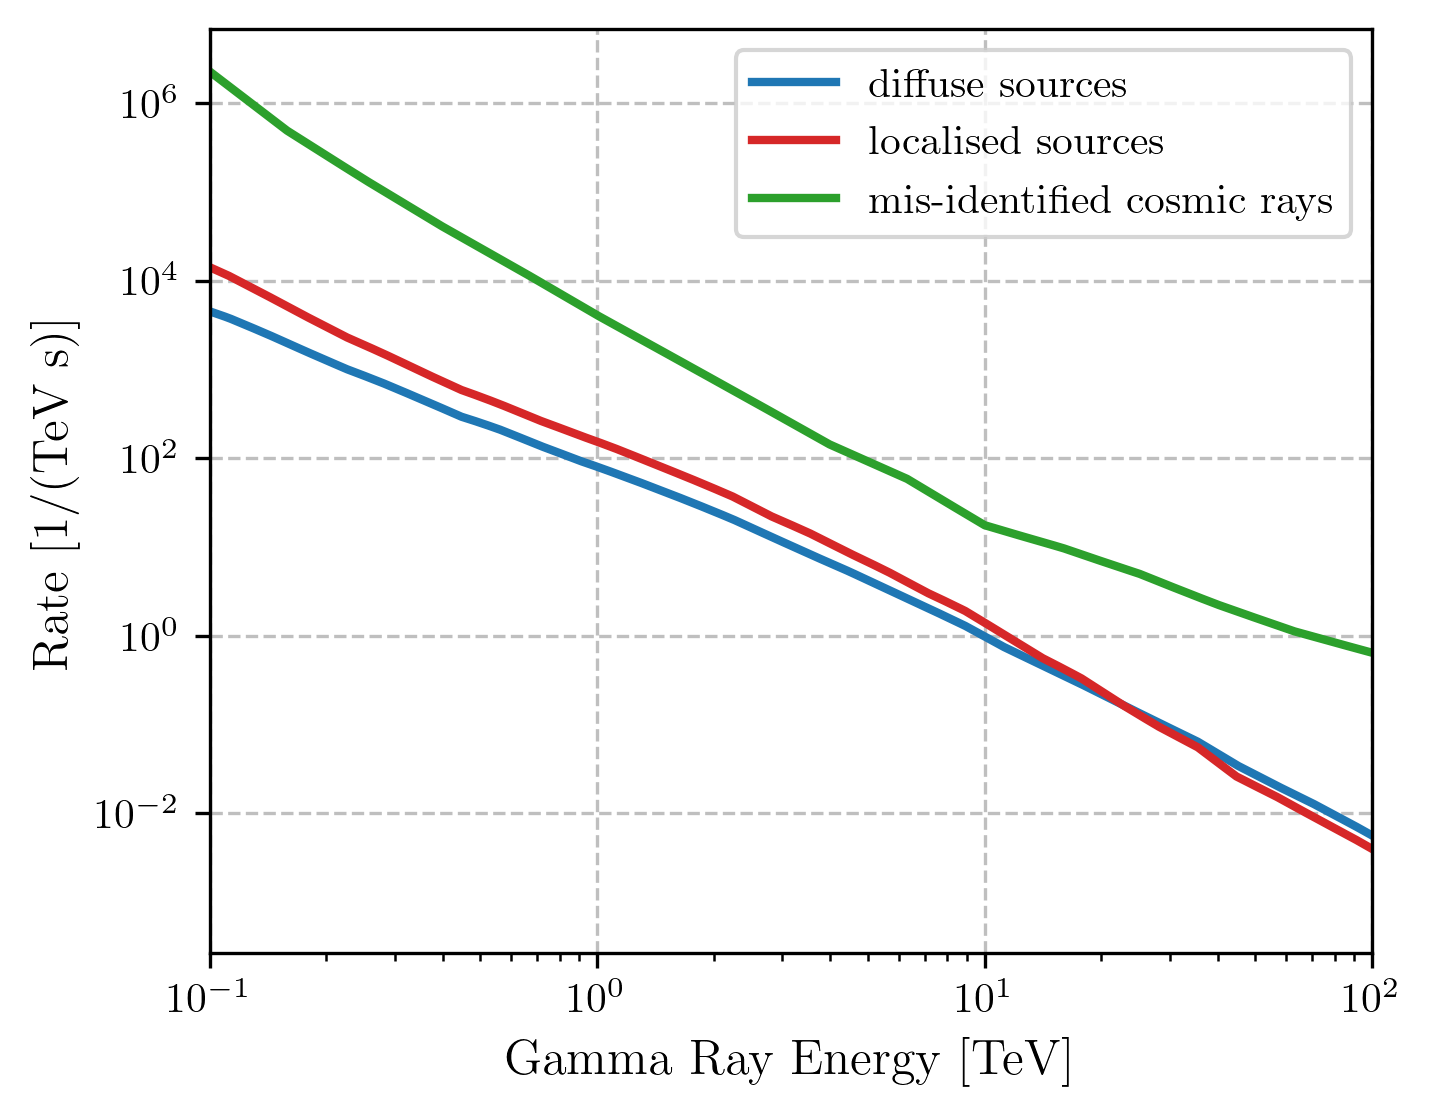

In [37]:
plt.figure(figsize=(5,4), dpi=300) 
plt.plot(10**log10eaxistrue, simps(y=simps(y=fermi_gaggero*aefftable, x=longitudeaxistrue, axis=1), 
                                   x=latitudeaxistrue, axis=1), 
         c="tab:blue", label='diffuse sources', lw=2)


plt.plot(10**log10eaxistrue, simps(y=simps(y=full_hess_flux*aefftable, x=longitudeaxistrue, axis=1), 
                                   x=latitudeaxistrue, axis=1), 
         c="tab:red", label='localised sources', lw=2)


# plt.plot(10**log10eaxistrue, simps(y=simps(y=combinedplotmapwithaeff, x=longitudeaxistrue, axis=1), 
#                                    x=latitudeaxistrue, axis=1), 
#          c="tab:purple]", label='all astro sources', lw=1)


plt.plot(10**log10eaxistrue, simps(y=simps(y=np.exp(bkgdist(log10emeshtrue, lonmeshtrue,latmeshtrue)), 
                                                    x=longitudeaxistrue, axis=1), x=latitudeaxistrue, axis=1), 
                                   c="tab:green", label='mis-identified cosmic rays', lw=2)

plt.xlim([1e-1,1e2])
plt.loglog()
plt.xlabel(r"Gamma Ray Energy [TeV]", size=12)
plt.ylabel(r"Rate [1/(TeV s)]", size=12)
plt.legend()
plt.grid(ls='--', c='grey', alpha=0.5)
plt.savefig('integrated_bkg_spectra.pdf')
plt.show()

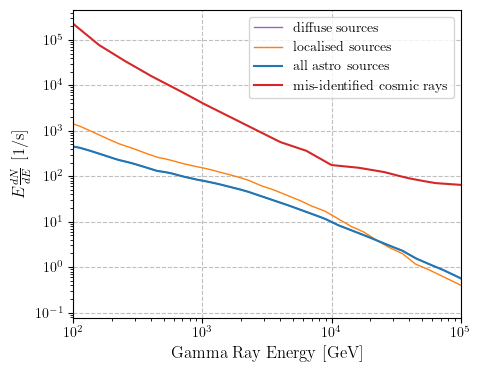

In [38]:
plt.figure(figsize=(5,4), dpi=100) 
plt.plot(10**(log10eaxistrue+3), simps(y=simps(y=fermi_gaggero*aefftable, x=longitudeaxistrue, axis=1), 
                                   x=latitudeaxistrue, axis=1)*10**log10eaxistrue, 
         c="tab:purple", label='diffuse sources', lw=1)


plt.plot(10**(log10eaxistrue+3), simps(y=simps(y=full_hess_flux*aefftable, x=longitudeaxistrue, axis=1), 
                                   x=latitudeaxistrue, axis=1)*10**log10eaxistrue, 
         c="tab:orange", label='localised sources', lw=1)


plt.plot(10**(log10eaxistrue+3), simps(y=simps(y=combinedplotmapwithaeff, x=longitudeaxistrue, axis=1), 
                                   x=latitudeaxistrue, axis=1)*10**log10eaxistrue, 
         c="tab:blue", label='all astro sources', lw=1.5)


plt.plot(10**(log10eaxistrue+3), simps(y=simps(y=np.exp(bkgdist(log10emeshtrue, lonmeshtrue,latmeshtrue)),
                                           x=longitudeaxistrue, axis=1), x=latitudeaxistrue, axis=1)*10**log10eaxistrue, 
                                   c="tab:red", label='mis-identified cosmic rays', lw=1.5)

plt.xlim([1e2,1e5])
plt.loglog()
plt.xlabel(r"Gamma Ray Energy [GeV]", size=12)
plt.ylabel(r"$E\frac{dN}{dE}$ [1/s]", size=12)
plt.legend()
plt.grid(ls='--', c='grey', alpha=0.5)
plt.show()

In [39]:
np.logspace(-2,2,10)

array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02])

The next recommended script for a overall walkthrough of the code is contained in ...